## Load libraries

In [14]:
from numpy.random import multinomial
from numpy import log, exp
from numpy import argmax
# import json
from tqdm.notebook import tqdm


class MovieGroupProcess:
    def __init__(self, K=8, alpha=0.1, beta=0.1, n_iters=30):
        '''
        A MovieGroupProcess is a conceptual model introduced by Yin and Wang 2014 to
        describe their Gibbs sampling algorithm for a Dirichlet Mixture Model for the
        clustering short text documents.
        Reference: http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf

        Imagine a professor is leading a film class. At the start of the class, the students
        are randomly assigned to K tables. Before class begins, the students make lists of
        their favorite films. The teacher reads the role n_iters times. When
        a student is called, the student must select a new table satisfying either:
            1) The new table has more students than the current table.
        OR
            2) The new table has students with similar lists of favorite movies.

        :param K: int
            Upper bound on the number of possible clusters. Typically many fewer
        :param alpha: float between 0 and 1
            Alpha controls the probability that a student will join a table that is currently empty
            When alpha is 0, no one will join an empty table.
        :param beta: float between 0 and 1
            Beta controls the student's affinity for other students with similar interests. A low beta means
            that students desire to sit with students of similar interests. A high beta means they are less
            concerned with affinity and are more influenced by the popularity of a table
        :param n_iters:
        '''
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.n_iters = n_iters

        # slots for computed variables
        self.number_docs = None
        self.vocab_size = None
        self.cluster_doc_count = [0 for _ in range(K)]
        self.cluster_word_count = [0 for _ in range(K)]
        self.cluster_word_distribution = [{} for i in range(K)]

    @staticmethod
    def from_data(K, alpha, beta, D, vocab_size, cluster_doc_count, cluster_word_count, cluster_word_distribution):
        '''
        Reconstitute a MovieGroupProcess from previously fit data
        :param K:
        :param alpha:
        :param beta:
        :param D:
        :param vocab_size:
        :param cluster_doc_count:
        :param cluster_word_count:
        :param cluster_word_distribution:
        :return:
        '''
        mgp = MovieGroupProcess(K, alpha, beta, n_iters=30)
        mgp.number_docs = D
        mgp.vocab_size = vocab_size
        mgp.cluster_doc_count = cluster_doc_count
        mgp.cluster_word_count = cluster_word_count
        mgp.cluster_word_distribution = cluster_word_distribution
        return mgp

    @staticmethod
    def _sample(p):
        '''
        Sample with probability vector p from a multinomial distribution
        :param p: list
            List of probabilities representing probability vector for the multinomial distribution
        :return: int
            index of randomly selected output
        '''
        return [i for i, entry in enumerate(multinomial(1, p)) if entry != 0][0]

    def fit(self, docs, vocab_size):
        '''
        Cluster the input documents
        :param docs: list of list
            list of lists containing the unique token set of each document
        :param V: total vocabulary size for each document
        :return: list of length len(doc)
            cluster label for each document
        '''
        alpha, beta, K, n_iters, V = self.alpha, self.beta, self.K, self.n_iters, vocab_size

        D = len(docs)
        self.number_docs = D
        self.vocab_size = vocab_size

        # unpack to easy var names
        m_z, n_z, n_z_w = self.cluster_doc_count, self.cluster_word_count, self.cluster_word_distribution
        cluster_count = K
        d_z = [None for i in range(len(docs))]

        # initialize the clusters
        for i, doc in tqdm(iterable=enumerate(docs), total=len(docs), desc="Sampling documents"):

            # choose a random  initial cluster for the doc
            z = self._sample([1.0 / K for _ in range(K)])

            d_z[i] = z
            m_z[z] += 1
            n_z[z] += len(doc)

            for word in doc:
                if word not in n_z_w[z]:
                    n_z_w[z][word] = 0
                n_z_w[z][word] += 1
        print('Sampling done!')

        iter_result = {
            "n_iters": [],
            "max_topics": [],
            "alpha": [],
            "beta": [],
            "iter": [], 
            "transferred_clusters": [], 
            "populated_clusters": []}

        for _iter in tqdm(iterable=range(n_iters), total=n_iters, desc="Iteration"):
            total_transfers = 0
            print('Iteration', _iter, '- alpha =', alpha, '- beta =', beta)

            for i, doc in tqdm(iterable=enumerate(docs), total=len(docs), desc="Transfering docs"):

                # remove the doc from it's current cluster
                z_old = d_z[i]

                m_z[z_old] -= 1
                n_z[z_old] -= len(doc)

                for word in doc:
                    n_z_w[z_old][word] -= 1

                    # compact dictionary to save space
                    if n_z_w[z_old][word] == 0:
                        del n_z_w[z_old][word]

                # draw sample from distribution to find new cluster
                p = self.score(doc)
                z_new = self._sample(p)

                # transfer doc to the new cluster
                if z_new != z_old:
                    total_transfers += 1

                d_z[i] = z_new
                m_z[z_new] += 1
                n_z[z_new] += len(doc)

                for word in doc:
                    if word not in n_z_w[z_new]:
                        n_z_w[z_new][word] = 0
                    n_z_w[z_new][word] += 1

            cluster_count_new = sum([1 for v in m_z if v > 0])
            print("In stage %d: transferred %d clusters with %d clusters populated" % (
                _iter, total_transfers, cluster_count_new))

            iter_result['n_iters'].append(n_iters)
            iter_result['max_topics'].append(K)
            iter_result['alpha'].append(alpha)
            iter_result['beta'].append(beta)
            iter_result['iter'].append(_iter)
            iter_result['transferred_clusters'].append(total_transfers)
            iter_result['populated_clusters'].append(cluster_count_new)

            if total_transfers == 0 and cluster_count_new == cluster_count and _iter > 25:
                print("Converged.  Breaking out.")
                break
            cluster_count = cluster_count_new
        self.cluster_word_distribution = n_z_w

        # d_z = cluster label for each document,
        # m_z = cluster_doc_count,
        # n_z = cluster_word_count,
        # n_z_w = cluster_word_distribution
        print('Modelling done!')
        return d_z, m_z, n_z, n_z_w, cluster_count, iter_result

    def score(self, doc):
        '''
        Score a document

        Implements formula (3) of Yin and Wang 2014.
        http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf

        :param doc: list[str]: The doc token stream
        :return: list[float]: A length K probability vector where each component represents
                              the probability of the document appearing in a particular cluster
        '''
        alpha, beta, K, V, D = self.alpha, self.beta, self.K, self.vocab_size, self.number_docs
        m_z, n_z, n_z_w = self.cluster_doc_count, self.cluster_word_count, self.cluster_word_distribution

        p = [0 for _ in range(K)]

        #  We break the formula into the following pieces
        #  p = N1*N2/(D1*D2) = exp(lN1 - lD1 + lN2 - lD2)
        #  lN1 = log(m_z[z] + alpha)
        #  lN2 = log(D - 1 + K*alpha)
        #  lN2 = log(product(n_z_w[w] + beta)) = sum(log(n_z_w[w] + beta))
        #  lD2 = log(product(n_z[d] + V*beta + i -1)) = sum(log(n_z[d] + V*beta + i -1))

        lD1 = log(D - 1 + K * alpha)
        doc_size = len(doc)
        for label in range(K):
            lN1 = log(m_z[label] + alpha)
            lN2 = 0
            lD2 = 0
            for word in doc:
                lN2 += log(n_z_w[label].get(word, 0) + beta)
            for j in range(1, doc_size + 1):
                lD2 += log(n_z[label] + V * beta + j - 1)
            p[label] = exp(lN1 - lD1 + lN2 - lD2)

        # normalize the probability vector
        pnorm = sum(p)
        pnorm = pnorm if pnorm > 0 else 1
        return [pp/pnorm for pp in p]

    def choose_best_label(self, doc):
        '''
        Choose the highest probability label for the input document
        :param doc: list[str]: The doc token stream
        :return:
        '''
        p = self.score(doc)
        return argmax(p), max(p)


In [23]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
import pandas as pd
import ast                      # convert string to list after importing csv data
# import tmtoolkit
import pickle

# Libraries to cluster data
# from gsdmm import MovieGroupProcess
from gensim.corpora import Dictionary

# Libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
# from cluster_visualization_helper import (
#     visualize_cluster  # user-defined functions
# )
from pprint import pprint

# Libraries for evaluation
from sklearn import metrics
from gensim.models import CoherenceModel

# Libraries for monitoring operation process
# from tqdm import tqdm
from datetime import datetime
# from pprint import pprint
# import logging

## Configurate and declare global variables

In [24]:
try:
    username = os.environ['HOSTNAME']
except:
    username = os.environ['COMPUTERNAME']

n_cpu = os.cpu_count()

os_name = os.name
username, n_cpu, os_name

('PINKA-ASUS-VIVO', 8, 'nt')

In [25]:
if os_name == 'nt':
    """Windows platform"""
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
    RESULT_DIR = BASE_DIR + "RESULTS/"

elif os_name == 'posix' and n_cpu < 4:
    """Linux platform"""
    if username == 'PinkaLinux':
        """Local env"""
        BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    elif n_cpu == 2:
        """Google Colab"""
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        BASE_DIR = "/content/drive/MyDrive/MASTER TILBURG/THESIS/"
        
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
    RESULT_DIR = BASE_DIR + "RESULTS/"
        
else:
    """Kaggle notebook"""
    BASE_DIR = "../input/dssthesis/"
    INPUT_DIR = BASE_DIR
    OUTPUT_DIR = "../working/"
    RESULT_DIR = OUTPUT_DIR + 'RESULTS/'
    if os.path.exists(RESULT_DIR) is False:
        os.mkdir(RESULT_DIR)
        print('Making dir', RESULT_DIR)
    else:
        print(RESULT_DIR, 'exists!')
    if os.path.exists(OUTPUT_DIR + "gsdmm/") is False:
        os.mkdir(OUTPUT_DIR + "gsdmm/")
        print('Making dir', OUTPUT_DIR + "gsdmm/")
    else:
        print(OUTPUT_DIR + "gsdmm/", 'exists!')
    if os.path.exists(RESULT_DIR + "gsdmm/") is False:
        os.mkdir(RESULT_DIR + "gsdmm/")
        print('Making dir', RESULT_DIR + "gsdmm/")
    else:
        print(RESULT_DIR + "gsdmm/", 'exists!')        

SEED = 6886

%matplotlib inline

## Import data

In [26]:
if n_cpu != 4:
    skill_embeddings = np.load(OUTPUT_DIR + "skill_feat_halfsize_embeddings.npy")
else:
    skill_embeddings = np.load(INPUT_DIR + "skill_feat_halfsize_embeddings.npy")
skill_embeddings.shape

(257205, 150)

In [27]:
if n_cpu != 4:
    skill_docs = pd.read_csv(
        OUTPUT_DIR + "skill_tokens_long_df.csv",
        converters={
            "skill_token": ast.literal_eval,
        },
        dtype={
            "key_id": int,
            "skill_id": int,
            "job_id": int,
            "column_type": str,
            "skill": str,
            "skill_lemma": str
        }
    )
else:
    skill_docs = pd.read_csv(
    INPUT_DIR + "skill_tokens_long_df.csv",
    converters={
        "skill_token": ast.literal_eval,
    },
    dtype={
        "key_id": int,
        "skill_id": int,
        "job_id": int,
        "column_type": str,
        "skill": str,
        "skill_lemma": str
    }
)
skill_docs.shape

(257205, 9)

In [28]:
skill_docs

,row_id,key_id,job_id,skill_id,column_id,column_type,skill,skill_lemma,skill_token
0,10101,101,1,1,1,job_description,ameria investment consulting company,ameria investment consult company,"[ameria, investment, consult, company]"
1,10201,102,1,2,1,job_description,requires high level,require high level,"[require, high, level]"
2,10301,103,1,3,1,job_description,provides highly responsible,provide highly responsible,"[provide, highly, responsible]"
3,10401,104,1,4,1,job_description,complex staff assistance,complex staff assistance,"[complex, staff, assistance]"
4,10501,105,1,5,1,job_description,chief financial officer,chief financial officer,"[chief, financial, officer]"
...,...,...,...,...,...,...,...,...,...
257200,190010103,1900101,19001,1,3,job_qualification,ra financial system,ra financial system,"[ra, financial, system]"
257201,190010203,1900102,19001,2,3,job_qualification,higher legal education,high legal education,"[high, legal, education]"
257202,190010303,1900103,19001,3,3,job_qualification,high pressure environment,high pressure environment,"[high, pressure, environment]"
257203,190010403,1900104,19001,4,3,job_qualification,professional work experience,professional work experience,"[professional, work, experience]"


## Clustering data

### Gibbs Sampling Dirichlet Mixture Model (GSDMM)

In [29]:
# Create doc list of clean job titles
doc_list = skill_docs["skill_lemma"].values.tolist()
pprint(doc_list[:10])

# Create corpus (list of tokens per document)
skill_corpus = skill_docs["skill_token"].values.tolist()
pprint(skill_corpus[:10])

# Create Dictionary
id2word = Dictionary(skill_corpus)

# # Term Document Frequency
model_corpus = [id2word.doc2bow(text) for text in skill_corpus]
pprint(model_corpus[:3])

['ameria investment consult company',
 'require high level',
 'provide highly responsible',
 'complex staff assistance',
 'chief financial officer',
 'irex currently seek',
 'position report directly',
 'cc program manager',
 'yerevan office',
 'community connection']
[['ameria', 'investment', 'consult', 'company'],
 ['require', 'high', 'level'],
 ['provide', 'highly', 'responsible'],
 ['complex', 'staff', 'assistance'],
 ['chief', 'financial', 'officer'],
 ['irex', 'currently', 'seek'],
 ['position', 'report', 'directly'],
 ['cc', 'program', 'manager'],
 ['yerevan', 'office'],
 ['community', 'connection']]
[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1)],
 [(7, 1), (8, 1), (9, 1)]]


In [30]:
skill_vocab = set([word for sublist in skill_corpus for word in sublist])
len(skill_vocab), list(skill_vocab)[:10]

(9330,
 ['expense',
  'mitsubishi',
  'ycap',
  'powerful',
  'ppmc',
  'codex',
  'theater',
  'intake',
  'personal',
  'mercury'])

In [11]:
def build_mgp_model(
    X,
    corpus,
    vocab_size,
    K=100,
    alpha=0.1,
    beta=0.1,
    n_iters=50,
    seed=6886,
):
    """
    A MovieGroupProcess is a conceptual model introduced by Yin and Wang 2014 to
    describe their Gibbs sampling algorithm for a Dirichlet Mixture Model for the
    clustering short text documents.
    Reference: http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf
    Imagine a professor is leading a film class. At the start of the class, the students
    are randomly assigned to K tables. Before class begins, the students make lists of
    their favorite films. The teacher reads the role n_iters times. When
    a student is called, the student must select a new table satisfying either:
        1) The new table has more students than the current table.
    OR
        2) The new table has students with similar lists of favorite movies.

    :param K: int
        Upper bound on the number of possible clusters. Typically many fewer
    :param alpha: float between 0 and 1
        Alpha controls the probability that a student will join a table that is currently empty
        When alpha is 0, no one will join an empty table.
    :param beta: float between 0 and 1
        Beta controls the student's affinity for other students with similar interests. A low beta means
        that students desire to sit with students of similar interests. A high beta means they are less
        concerned with affinity and are more influenced by the popularity of a table
    """
    np.random.seed(SEED)
    mgp = MovieGroupProcess(K=K, alpha=alpha, beta=beta, n_iters=n_iters)

    """
        MovieGroupProcess().fit: Cluster the input documents
        :param docs: list of list
            list of lists containing the unique token set of each document
        :param V: total vocabulary size for each document
        :return:
            # d_z = cluster label for each document,
            # m_z = cluster_doc_count,
            # n_z = cluster_word_count,
            # n_z_w = cluster_word_distribution
            # cluster_count = number of clusters found
    """
    #     mgp_labels = mgp.fit(docs=corpus, vocab_size=vocab_size)
    d_z, m_z, n_z, n_z_w, cluster_count, iter_result = mgp.fit(
        docs=corpus, vocab_size=vocab_size
    )

    return mgp, d_z, m_z, n_z, n_z_w, cluster_count, iter_result

## Tuning hyperparameters

In [29]:
# Preparing hyperparameters for tuning
n_iters = 5
# n_iters = 2

# Topics range
topic_range = [200]

# Alpha parameter
alpha_range = [0.001, 0.5]
# alpha_range = [0.001]

# Beta parameter
beta_range = [0.001, 0.5]
# beta_range = [0.001]

tuning_result = {
    "n_iters": [],
    "max_topics": [],
    "alpha": [],
    "beta": [],
    "duration": [],
    "n_clusters": [],
}

model_list = []
label_list = []
topics_list = []
iter_result_list = []
distribution_dict = {
    "n_iters": [],
    "max_topics": [],
    "alpha": [],
    "beta": [],
    "m_z": [],
    "n_z": [],
    "n_z_w": [],
}
# m_z = cluster_doc_count,
# n_z = cluster_word_count,
# n_z_w = cluster_word_distribution
# cluster_count = number of clusters found

In [30]:
print(topic_range)
print(alpha_range)
print(beta_range)
print(
    len(topic_range),
    len(alpha_range),
    len(beta_range),
    len(topic_range) * len(alpha_range) * len(beta_range),
)

[2]
[0.001]
[0.001]
1 1 1 1


In [31]:
# Tuning GSDMM to find optimal number of topics
pbar = tqdm(
    desc="GSDMM tuning",
    total=len(topic_range) * len(alpha_range) * len(beta_range),
)

# iterate through number of topics
for max_topics in topic_range:
    # iterate through alpha values
    for alpha in alpha_range:
        # iterare through beta values
        for beta in beta_range:
            # Train model
            starttime = datetime.now()
            print("Start", starttime.strftime("%Y-%m-%d %H:%M:%S.%f"))
            print("max_topics =", max_topics)
            print("n_iters =", n_iters)
            print("alpha =", alpha)
            print("beta =", beta)

            (
                clusterer,
                labels,
                m_z,
                n_z,
                n_z_w,
                n_clusters,
                iter_result,
            ) = build_mgp_model(
                X=skill_docs,
                corpus=skill_corpus,
                vocab_size=len(skill_vocab),
                K=max_topics,
                alpha=alpha,
                beta=beta,
                n_iters=n_iters,
                seed=SEED,
            )

            endtime = datetime.now()
            print("End", endtime.strftime("%Y-%m-%d %H:%M:%S.%f"))
            print("Duration", endtime - starttime)

            # Save model
            pickle.dump(
                clusterer,
                open(
                    OUTPUT_DIR
                    + "gsdmm/"
                    + "skill_gsdmm_model_max_topics-"
                    + str(max_topics)
                    + "_n_iters-"
                    + str(n_iters)
                    + "_alpha-"
                    + str(alpha)
                    + "_beta-"
                    + str(beta)
                    + ".pkl",
                    "wb",
                ),
            )

            model_list.append(clusterer)
            label_list.append(labels)

            # Save the model results
            tuning_result["n_iters"].append(n_iters)
            tuning_result["max_topics"].append(max_topics)
            tuning_result["alpha"].append(alpha)
            tuning_result["beta"].append(beta)
            tuning_result["duration"].append(
                round((endtime - starttime).seconds / 60, 4)
            )
            tuning_result["n_clusters"].append(n_clusters)

            distribution_dict["n_iters"].append(n_iters)
            distribution_dict["max_topics"].append(max_topics)
            distribution_dict["alpha"].append(alpha)
            distribution_dict["beta"].append(beta)
            distribution_dict["m_z"].append(m_z)
            distribution_dict["n_z"].append(n_z)
            distribution_dict["n_z_w"].append(n_z_w)

            topic_word_list = []
            for i in range(len(n_z_w)):
                topic_word_list.append(list(n_z_w[i].keys()))
            topics_list.append(topic_word_list)

            # {"iter", "transferred_clusters", "populated_clusters"}
            iter_result_list.append(iter_result)
            pbar.update(1)
pbar.close()

GSDMM tuning:   0%|          | 0/1 [00:00<?, ?it/s]

Start 2021-05-20 19:56:15.724199
max_topics = 2
n_iters = 1
alpha = 0.001
beta = 0.001


Sampling documents:   0%|          | 0/257205 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Transfering docs:   0%|          | 0/257205 [00:00<?, ?it/s]

In stage 0: transferred 125631 clusters with 2 clusters populated
End 2021-05-20 19:56:50.055320
Duration 0:00:34.331121


In [11]:
def compute_evaluation_metrics(topics, corpus, dictionary, texts):
    """
    Compute umass, c_v coherence and perplexity for various number of topics

    Parameters:
    ----------
    topics: list of topic words produced by topic model
    corpus: Gensim corpus
    dictionary: Gensim dictionary
    texts: List of input texts

    Returns:
    -------
    coherence_umass: UMASS Coherence value with respective number of topics
    coherence_cv: C_V Coherence value with respective number of topics
    """
    print('Computing UMASS')
    umass_coherence_model = CoherenceModel(
        topics=topics, texts=texts, dictionary=dictionary, coherence="u_mass"
    )
    coherence_umass = umass_coherence_model.get_coherence()
    print('Done computing UMASS')

    print('Computing CV')
    cv_model = CoherenceModel(
        topics=topics, texts=texts, dictionary=dictionary, coherence="c_v"
    )
    coherence_cv = cv_model.get_coherence()
    print('Done computing CV')
#     perplexity_value = model.log_perplexity(corpus)

    return coherence_umass, coherence_cv, #perplexity_value

In [34]:
evaluation_result = {}
evaluation_result["coherence_umass"] = []
evaluation_result["coherence_cv"] = []
# tuning_result["perplexity"] = []

for idx, i in tqdm(
    desc="Computing GSDMM Coherence",
    total=len(model_list),
    iterable=enumerate(model_list),
):
    print("Computing GSDMM Coherence for model", idx)
    umass_score, cv_score = compute_evaluation_metrics(
        topics_list[idx],
        corpus=model_corpus,
        dictionary=id2word,
        texts=skill_corpus,
    )
    evaluation_result["coherence_umass"].append(umass_score)
    evaluation_result["coherence_cv"].append(cv_score)
#     evaluation_result["perplexity"].append(perplexity)
print("Done Computing GSDMM Coherence for model", idx)

Computing GSDMM Coherence:   0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
# Display tuning results
tuning_result_df = pd.DataFrame(tuning_result)
tuning_result_df

,n_iters,max_topics,alpha,beta,duration,n_clusters
0,1,2,0.001,0.001,0.5667,2


In [36]:
# Display evaluation_result
evaluation_result_df = pd.DataFrame(evaluation_result)
evaluation_result_df

,coherence_umass,coherence_cv
0,-12.971517,0.637518


In [39]:
# Save tuning results
tuning_result_df.to_csv(
    RESULT_DIR + "gsdmm/" + "skill_gsdmm_tuning_result.csv", index=False
)

In [40]:
# Save tuning results
evaluation_result_df.to_csv(
    RESULT_DIR + "gsdmm/" + "skill_gsdmm_evaluation_result.csv", index=False
)

In [41]:
# Combine model sets
tuple_objects = (
    model_list,
    topics_list,
    label_list,
    distribution_dict,
    tuning_result,
    evaluation_result,
    iter_result_list
)
len(tuple_objects), len(tuple_objects[0])

(6, 1)

In [42]:
# Save tuple of model sets
pickle.dump(
    tuple_objects, open(RESULT_DIR + "gsdmm/" + "skill_gsdmm_model_tuning_list.pkl", "wb")
)

In [15]:
# # Load tuple of model sets
# (
#     model_list,
#     topics_list,
#     label_list,
#     distribution_dict,
#     tuning_result,
#     evaluation_result,
#     iter_result_list
# ) = pickle.load(
#     open(RESULT_DIR + "gsdmm/" + "skill_gsdmm_model_tuning_list.pkl", "rb")
# )

In [18]:
# # Load tuning results
# evaluation_result_df = pd.read_csv(
#     RESULT_DIR + "gsdmm/" + "skill_gsdmm_evaluation_result.csv"
# )
# evaluation_result_df

,n_iters,max_topics,alpha,beta,duration,n_clusters,coherence_umass,coherence_cv
0,5,200,0.001,0.001,83.3833,200,-11.706332,0.527687
1,5,200,0.001,0.500,83.7167,117,NaN,NaN
2,5,200,0.500,0.001,84.4333,200,-11.778291,0.530342
3,5,200,0.500,0.500,84.5167,121,NaN,NaN


In [19]:
# Load tuning results
tuning_result_df = pd.read_csv(
    RESULT_DIR + "gsdmm/" + "skill_gsdmm_tuning_result.csv"
)
tuning_result_df

,n_iters,max_topics,alpha,beta,duration,n_clusters
0,5,200,0.001,0.001,83.3833,200
1,5,200,0.001,0.500,83.7167,117
2,5,200,0.500,0.001,84.4333,200
3,5,200,0.500,0.500,84.5167,121


In [16]:
# List of markers for subplots
marker_dict = {
#     ".": "point",
#     ",": "pixel",
    "o": "circle",
    "v": "triangle_down",
    "^": "triangle_up",
    "<": "triangle_left",
    ">": "triangle_right",
    "1": "tri_down",
    "2": "tri_up",
    "3": "tri_left",
    "4": "tri_right",
    "8": "octagon",
    "s": "square",
    "p": "pentagon",
    "*": "star",
    "h": "hexagon1",
    "H": "hexagon2",
    "+": "plus",
    "x": "x",
    "D": "diamond",
    "d": "thin_diamond",
    "|": "vline",
    "_": "hline",
    "P": "plus_filled",
    "X": "x_filled",
    0: "tickleft",
    1: "tickright",
    2: "tickup",
    3: "tickdown",
    4: "caretleft",
    5: "caretright",
    6: "caretup",
    7: "caretdown",
    8: "caretleftbase",
    9: "caretrightbase",
    10: "caretupbase",
    11: "caretdownbase",
}
marker_list = list(marker_dict.keys())

## Evaluation metrics

#### Topic coherence

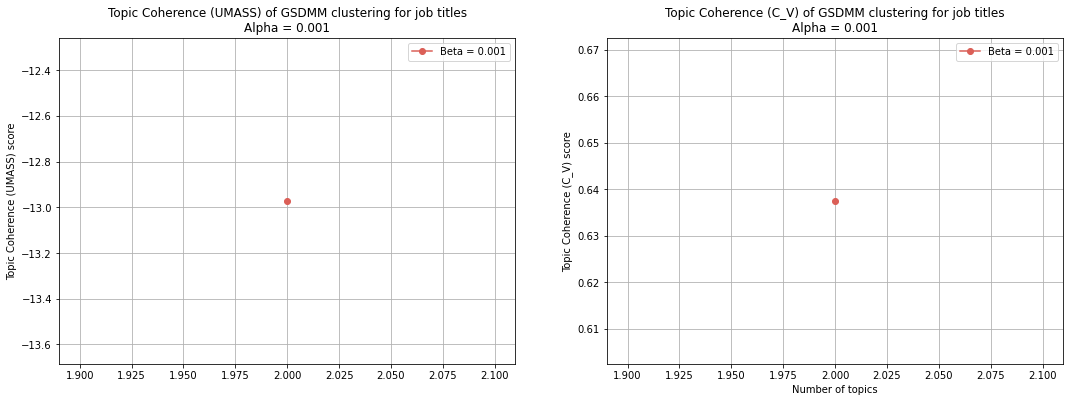

In [46]:
palette = sns.color_palette("hls", n_colors=len(beta_range))

# The higher the better

for ida, alpha in enumerate(alpha_range):
    fig = plt.figure(figsize=(18, 6))
    for idx, beta in enumerate(beta_range):
        # Plot UMASS coherence
        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(
            tuning_result_df["n_clusters"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            evaluation_result_df["coherence_umass"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            label="Beta = " + str(beta),
            color=palette[idx],
            marker=marker_list[idx],
        )
        ax1.set_ylabel("Topic Coherence (UMASS) score")
        # plt.xticks(np.unique(model_result_df["min_samples"]))
        ax1.set_title(
            "Topic Coherence (UMASS) of GSDMM clustering for job titles\n"
            + "Alpha = "
            + str(alpha)
        )
        ax1.legend(loc="best")

        # Plot C_V coherence
        ax2 = plt.subplot(1, 2, 2)
        ax2.plot(
            tuning_result_df["n_clusters"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            evaluation_result_df["coherence_cv"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            label="Beta = " + str(beta),
            color=palette[idx],
            marker=marker_list[idx],
        )
        ax2.set_ylabel("Topic Coherence (C_V) score")
        # plt.xticks(np.unique(model_result_df["min_samples"]))
        ax2.set_title(
            "Topic Coherence (C_V) of GSDMM clustering for job titles\n"
            + "Alpha = "
            + str(alpha)
        )
        ax2.set_xlabel("Number of topics")
        # plt.yticks(np.unique(model_result_df["number_clusters"]))

        ax2.legend(loc="best")
    ax1.grid()
    ax2.grid()

    # Saving plot as image
    fig.savefig(
        RESULT_DIR
        + "gsdmm/"
        + "title_gsdmm_coherence_alpha-"
        + str(alpha)
        + "_plot.png",
        #     bbox_inches="tight",
        #     dpi=150,
    )

    # Show plot
    plt.show()

In [21]:
# Select the GSDMM model with optimal number of clusters
best_index = np.argmax(evaluation_result_df["coherence_cv"].values)
# best_index = int(
#     np.where(
#         (np.array(tuning_result["alpha"]) == 0.001)
#         & (np.array(tuning_result["beta"]) == 0.001)
#         & (np.array(tuning_result["n_topics"]) == 25)
#     )[0]
# )
print("Index of best coherence score", best_index)
best_n_clusters = tuning_result_df["n_clusters"][best_index]
best_alpha = tuning_result_df["alpha"][best_index]
best_beta = tuning_result_df["beta"][best_index]

print(
    f"Optimal number of clusters = {best_n_clusters}, best alpha = {best_alpha}, best beta = {best_beta}"
)

Index of best coherence score 1
Optimal number of clusters = 117, best alpha = 0.001, best beta = 0.5


In [22]:
X = skill_embeddings
best_labels = label_list[best_index]
model_validation = {
    "n_clusters": [best_n_clusters],
    "alpha": [best_alpha],
    "beta": [best_alpha],
}

NameError: name 'label_list' is not defined

In [49]:
print('Computing silhouette')
model_validation["silhouette"] = []
model_validation["silhouette_error"] = []

try:
    silhouette = metrics.silhouette_score(
        X, best_labels, sample_size=10000, random_state=SEED, n_jobs=-1
    )
    model_validation["silhouette_error"].append("None")
except Exception as e:
    print(e)
    silhouette = -1.1
    model_validation["silhouette_error"].append(e)
model_validation["silhouette"].append(silhouette)

In [50]:
print('Computing calinski_harabasz')
model_validation["calinski_harabasz"] = []
model_validation["calinski_harabasz_error"] = []

try:
    calinski_harabasz = metrics.calinski_harabasz_score(X, best_labels)
    model_validation["calinski_harabasz_error"].append("None")
except Exception as e:
    print(e)
    calinski_harabasz = -1.1
    model_validation["calinski_harabasz_error"].append(e)
model_validation["calinski_harabasz"].append(calinski_harabasz)

In [51]:
print('Computing davies_bouldin')
model_validation["davies_bouldin"] = []
model_validation["davies_bouldin_error"] = []

try:
    davies_bouldin = metrics.davies_bouldin_score(X, best_labels)
    model_validation["davies_bouldin_error"].append("None")
except Exception as e:
    print(e)
    davies_bouldin = -1.1
    model_validation["davies_bouldin_error"].append(e)
model_validation["davies_bouldin"].append(davies_bouldin)

In [52]:
# model_validation["silhouette_corr"] = []
# model_validation["silhouette_corr_error"] = []

# try:
#     silhouette = metrics.silhouette_score(
#         X,
#         best_labels,
#         sample_size=10000,
#         random_state=SEED,
#         n_jobs=-1,
#         metric="correlation",
#     )
#     model_validation["silhouette_corr_error"].append("None")
# except Exception as e:
#     print(e)
#     silhouette = -1.1
#     model_validation["silhouette_corr_error"].append(e)
# model_validation["silhouette_corr"].append(silhouette)

In [53]:
# Display validation results
model_validation_df = pd.DataFrame(model_validation)
model_validation_df

,n_clusters,alpha,beta,silhouette,silhouette_error,calinski_harabasz,calinski_harabasz_error,davies_bouldin,davies_bouldin_error,silhouette_corr,silhouette_corr_error
0,2,0.001,0.001,-0.000003,None,0.820917,None,538.826965,None,0.0,None


In [54]:
# Save tuning results
model_validation_df.to_csv(
    RESULT_DIR + "gsdmm/" + "skill_gsdmm_model_validation.csv", index=False
)

## Display top words of each cluster

In [43]:
# Load tuple of model sets
(sorted_wordcount, topwords, sorted_wordcount2, topwords2, best_topics) = pickle.load(
    open(RESULT_DIR + "gsdmm/" + "title_gsdmm_optimal-topwords.pkl", "rb"),
)

In [ ]:
df_clusters = skill_docs.copy(deep=True)
df_clusters["model_type"] = "gsdmm"
df_clusters["skill_n_clusters"] = best_n_clusters
# df_clusters["embeddings"] = "job_title"
df_clusters['skill_cluster_label'] = best_labels
df_clusters

In [45]:
df_clusters = pd.read_csv(
    RESULT_DIR + "gsdmm/" + "title_gsdmm_optimal-cluster-labels.csv"
)

In [46]:
wordcount = {}
sorted_wordcount = {}
for i in np.unique(df_clusters["title_cluster_label"].values):
    skills = df_clusters[df_clusters["title_cluster_label"] == i][
        "job_title_lemma"
    ].values
    skills = " ".join(" ".join(skills).split())
    wordcount[i] = {}
    for j in skills.split():
        if j in wordcount[i]:
            wordcount[i][j] += 1
        else:
            wordcount[i][j] = 1
    sorted_wordcount[i] = sorted(wordcount[i].items(), key=lambda x: x[1], reverse=True)

In [47]:
topwords = {}
for key, i in sorted_wordcount.items():
    print("Cluster "+str(key)+": ", end='')
    topwords[key] = ''
    for newkey, j in sorted_wordcount[key][:10]:
        print(newkey + '|', end='')
        topwords[key] = topwords[key] + newkey + '|'
    print()

Cluster 0: copywriter|
Cluster 6: assurance|quality|engineer|software|specialist|tester|revenue|senior|analyst|fraud|
Cluster 13: lobby|ambassador|concierge|
Cluster 20: educational|information|fair|administrative|assistant|civic|civil|data|managment|analist|
Cluster 21: language|english|translator|course|interpreter|teacher|editor|specialist|instructor|armenian|
Cluster 22: human|resource|department|head|specialist|policy|financial|economist|management|unit|
Cluster 23: medical|representative|yerevan|doctor|armenia|tb|gyumri|sale|mobile|journalist|
Cluster 26: specialist|manager|officer|marketing|department|head|senior|financial|project|analyst|
Cluster 27: short|term|local|penitentiary|healthcare|armenia|lot|consultancy|service|consultant|
Cluster 34: grafik|interior|exterior|designer|activity|examiner|animation|
Cluster 45: student|forum|lecture|swedish|equal|opportunity|ombudsman|conference|debate|april|
Cluster 48: instructor|bank|legislation|
Cluster 49: coop|tech|precision|analo

In [39]:
best_n_clusters

117

In [37]:
best_topics = distribution_dict["n_z_w"][best_index]
sorted_wordcount2 = {}
for i in range(best_n_clusters):
    sorted_wordcount2[i] = sorted(
        best_topics[i].items(), key=lambda x: x[1], reverse=True
    )

In [38]:
topwords2 = {}
for key, i in sorted_wordcount2.items():
    print("Cluster "+str(key)+": ", end='')
    topwords2[key] = ''
    for newkey, j in sorted_wordcount2[key][:10]:
        print(newkey + '|', end='')
        topwords2[key] = topwords2[key] + newkey + '|'
    print()

Cluster 0: server|sql|database|ms|window|system|application|web|microsoft|language|
Cluster 1: 
Cluster 2: design|circuit|analog|operation|print|drawing|layout|perform|approve|respective|
Cluster 3: highly|responsible|motivated|personality|qualified|person|seek|self|professional|candidate|
Cluster 4: engine|draw|search|corel|optimization|concern|group|constant|conclusion|technology|
Cluster 5: 
Cluster 6: test|multiple|manage|task|testing|automate|case|develop|project|write|
Cluster 7: 
Cluster 8: user|center|interface|career|announce|pc|advanced|design|web|experience|
Cluster 9: news|employment|agency|post|handling|arka|harvest|contract|letter|edit|
Cluster 10: 
Cluster 11: enterprise|dart|doubleclick|grade|system|th|technology|new|formation|accelerate|
Cluster 12: system|grow|home|company|enhance|come|molorak|inco|letter|craft|
Cluster 13: cover|special|business|writing|plan|thoroughly|test|ensure|logic|virage|
Cluster 14: foundation|jinishian|memorial|national|competitiveness|seismo

## Save cluster results to file

In [64]:
df_clusters.to_csv(
    RESULT_DIR + "gsdmm/" + "skill_gsdmm_optimal-cluster-labels.csv", index=False
)

In [65]:
# Save tuple of model sets
pickle.dump(
    (sorted_wordcount, topwords, sorted_wordcount2, topwords2, best_topics),
    open(RESULT_DIR + "gsdmm/" + "skill_gsdmm_optimal-topwords.pkl", "wb"),
)